In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc
import nltk
from gensim import models
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

plt.style.use('fivethirtyeight')

This dataset is a small, more managable version of the full reddit dataset. It contains ~700000 comments from 1300 users who have the word 'bot' in their name. This data is used to evaluate models since I can more easily identify bots. The full dataset can be found in the "predicting reddit user location" project.

In [16]:
botComments_df = pd.read_csv('sampleAuthors.csv')

In [17]:
botComments_df.head(5)

,author,body,subreddit
0,000000robot,"Place in plastic bag, seal it and put in freez...",techsupport
1,000000robot,Listen.\n\nShe doesn't need a hero. She alread...,TwoXChromosomes
2,000000robot,So do people think she is POTUS? I am confused.,politics
3,000000robot,Yes! Agree.\n\nHe was in the hospital and vulu...,GilmoreGirls
4,000000robot,Mmmm ... I would do mem checks and basic tests...,techsupport


In [18]:
#These authors only have stop words
botComments_df = botComments_df[~botComments_df['author'].isin(['timezone_bot', 'cool-acronym-bot', 'table_it_bot'])]

In [19]:
botComments_df.describe()

,author,body,subreddit
count,670495,670494,670495
unique,1319,469813,17465
top,MemeInvestor_bot,\nYour request does not link to a valid subred...,MemeEconomy
freq,158619,41956,166343


In [20]:
botComments_df.isna().sum()

author       0
body         1
subreddit    0
dtype: int64

In [21]:
botComments_df = botComments_df.dropna()

In [22]:
botComments_df.groupby(['author'], as_index = False).count().describe()

,body,subreddit
count,1319.000000,1319.000000
mean,508.335102,508.335102
std,5176.632208,5176.632208
min,41.000000,41.000000
25%,58.000000,58.000000
50%,93.000000,93.000000
75%,189.000000,189.000000
max,158619.000000,158619.000000


**Cosine similarites**

Get the average cosine similarities of each author. This is quite inefficient since getting the average cosine similarities requires n^2 comparisions, where n is the number of comments the author has written. To reduce compute time, authors with more than 2000 comments will have 2000 comments randomly sampled as a representation of that author's work. 

This uses a bag-of-words model, which is essentially looking at what words the author uses - we lose information about what order these words appeared in. The count vectorizer is qutie simple and simply counts the number of times each word appears in the author's comment. The term frequency-inverse document frequency (tfidf) value for a word increases as it appears but it is also offset by the number of times it appears in other comments in the user's comment history. That is, words that appear frequently in all texts are considered less important in a tfidf vectorizer compared to a simple count vectorizer.

In [23]:
import time


def getCosineSimilarity(data, vectorizerType = 'Count'):
    uniqueAuthors = data.author.unique()
    similarities_df = pd.DataFrame(columns = ['author', 'similarity']) 
    
    count_df = data.groupby(['author'], as_index = False).count()
    highVolumeAuthors = count_df[count_df['body']>2000]['author'].tolist()
    for auth in uniqueAuthors:
        if vectorizerType=='Count':
            vectorizer = CountVectorizer(strip_accents = 'unicode')
        else:
            vectorizer = TfidfVectorizer()
        
        
        authorData = data[data['author'] == auth]
        #sample
        if auth in highVolumeAuthors:
            authorData = authorData.sample(n=2000, random_state = 1)
        
        X = vectorizer.fit_transform(authorData['body'])
        avgCosSimilarity = cosine_similarity(X).mean()
        similarities_df = similarities_df.append({'author':auth, 'similarity':avgCosSimilarity}, ignore_index=True)
        
    return similarities_df




In [24]:
start = time.time()
countVecSimilarities = getCosineSimilarity(botComments_df)
end = time.time()
print(end-start)

66.95423078536987


In [25]:
start = time.time()
tfidfVecSimilarities = getCosineSimilarity(botComments_df, 'Tfidf')
end = time.time()
print(end-start)



64.56257271766663


In [26]:
comparison_df = countVecSimilarities.join(tfidfVecSimilarities, rsuffix='_tfid')
comparison_df = comparison_df.drop(columns=['author_tfid'])
comparison_df['difference'] = comparison_df['similarity']-comparison_df['similarity_tfid']
comparison_df.sort_values(by='difference', ascending=False).head(20)

,author,similarity,similarity_tfid,difference
329,RedditSilverRobot,0.877908,0.148133,0.729775
928,maybemaybemaybe_bot,0.942903,0.219966,0.722937
1011,onewordeachbot,0.857519,0.135442,0.722076
813,gwcoep_bot,0.783199,0.071738,0.711461
910,livestreamfailsbot,0.790212,0.102886,0.687326
1151,rosey-the-bot,0.896752,0.212670,0.684082
1193,sneakpeekbot,0.808377,0.126258,0.682119
1029,phcsaucebot,0.879859,0.201567,0.678292
1056,qznc_bot,0.956560,0.289458,0.667102
822,hearthscan-bot,0.830052,0.164673,0.665380


The tfidf vectorizer is guarunteed to find less (or equal) average similarity in each user's comment history. For the purposes of this project, using a count vectorizer seems like a better choice. 

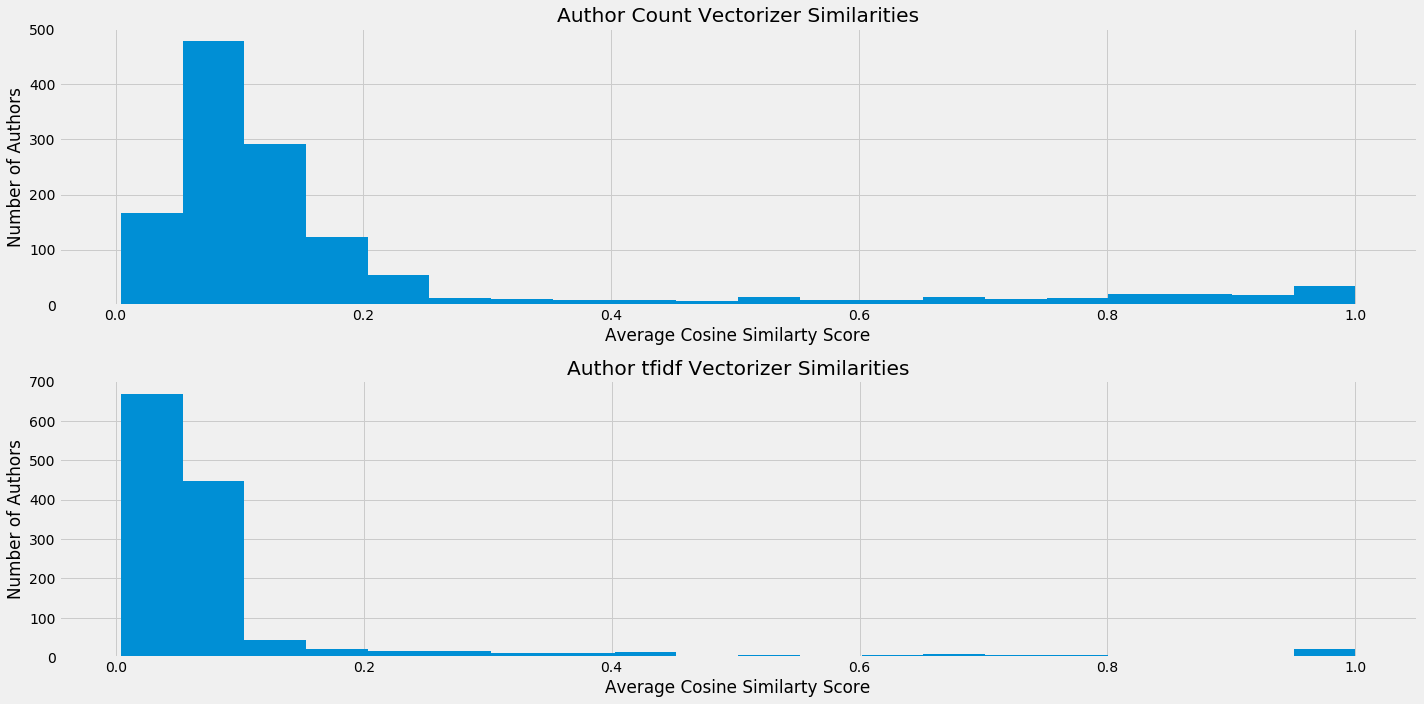

In [27]:
plt.rcParams["figure.figsize"] = [20,10]

plt.subplot(2,1, 1)
plt.hist(countVecSimilarities['similarity'], bins = 20)
plt.xlabel('Average Cosine Similarty Score')
plt.ylabel('Number of Authors')
plt.title('Author Count Vectorizer Similarities')

plt.subplot(2,1, 2)   
plt.hist(tfidfVecSimilarities['similarity'], bins = 20)
plt.xlabel('Average Cosine Similarty Score')
plt.ylabel('Number of Authors')
plt.title('Author tfidf Vectorizer Similarities')

plt.tight_layout()

Here is the output (for now) of author's that are likely bots. I'll threshold bots as users who's count vectorizer similarity is about .4. This number can be reduced but after manually looking through some comments histories of

In [32]:
#comparison_df = comparison_df.drop(columns = ['subreddit'])
comparison_df[comparison_df['similarity']>.4].sort_values(by='similarity')['author']

,author,similarity,similarity_tfid,difference
975,nautbot,0.408031,0.282643,1.253887e-01
896,kuilinbot,0.410314,0.095323,3.149912e-01
958,mredinlaw_bot,0.419936,0.409113,1.082283e-02
1177,serendipitybot,0.424828,0.112616,3.122124e-01
719,d3posterbot,0.428849,0.199018,2.298304e-01
1043,porntipsguzzardobot,0.435612,0.360071,7.554128e-02
766,fantasywritersbot,0.437135,0.407690,2.944557e-02
565,alternate-source-bot,0.451959,0.069512,3.824471e-01
678,bravo_delta_bot,0.465766,0.095014,3.707519e-01
83,ContextualRobot,0.474311,0.078335,3.959761e-01
